[![Open In nbviewer](https://img.shields.io/badge/Jupyter-nbviewer-orange?logo=jupyter)](
https://nbviewer.org/github/RadyaSRN/intent-classification-for-QA-chatbot/blob/main/notebooks/intent_classification.ipynb)
[![Open In Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](
https://www.kaggle.com/kernels/welcome?src=https://github.com/RadyaSRN/intent-classification-for-QA-chatbot/blob/main/notebooks/intent_classification.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/RadyaSRN/intent-classification-for-QA-chatbot/blob/main/notebooks/intent_classification.ipynb)
[![W&B Report](https://img.shields.io/badge/Weights%20&%20Biases-Report-orange?logo=weightsandbiases)](
https://wandb.ai/radyasrn-mipt/NLP-spring-2025/reports/intent-classification-for-QA-chatbot--VmlldzoxNDI1MzExMg)

<b><font size=6>**Introduction**</font></b>

The notebook is divided into steps:

- [Step 1: Exploratory Data Analysis](#step-1-exploratory-data-analysis)
- [Step 2: RuBERT Model](#step-2-rubert-model)
- [Step 3: RuBERT Model with Gradual Training Setup](#step-3-rubert-model-with-gradual-training-setup)
- [Step 4: RuBERT Model with Augmentex Augmentations](#step-4-rubert-model-with-augmentex-augmentations)
- [Step 5: Final Comparison of Models](#step-5-final-comparison-of-models)

This notebook presents a pipeline for training of the **[RuBERT](https://huggingface.co/DeepPavlov/rubert-base-cased) model** on, its modifications, and using various techniques for the classification of user intents in their requests to the university QA chatbot from the Novosibirsk State University **[dataset](https://www.kaggle.com/datasets/constantinwerner/qa-intents-dataset-university-domain)**.

![Illustration](../images/intent-classification-illustration.png)

The project was carried out in a Kaggle environment with a P100 GPU.

Let's make the necessary imports:

In [ ]:
import numpy as np
import os
import pandas as pd
import torch
import wandb
from datasets import Dataset
from safetensors.torch import load_file
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    AutoModel,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from tqdm.notebook import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style="whitegrid")

# Models and utils
from src.models import
from src.dataset import
from src.utils import

<a name="step-1-exploratory-data-analysis"></a>
<b><font size=4>**Step $1$</font></b> <b><font size=2>(Exploratory Data Analysis):**</font></b>

In this step, we will examine our data.

Let's look at the sizes of the datasets:

In [ ]:
train_path = "/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv"
test_path = "/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv"

train_df = pd.read_csv(train_path, sep="\t", header=None, names=["text", "label"])
test_df = pd.read_csv(test_path, sep="\t", header=None, names=["text", "label"])

print("Train dataset size:", len(train_df))
print("Test dataset size:", len(test_df))

Train dataset size: 13230
Test dataset size: 883


We can see that the train is quite large compared to the test. Let's look at the average number of samples per class:

In [ ]:
label_counts = train_df["label"].value_counts()
mean_samples_per_class = label_counts.mean()

print("Average sample count per class:", f'{mean_samples_per_class:.2f}')
print("Unique class count:", label_counts.shape[0])

Average sample count per class: 93.17
Unique class count: 142


Next, let's look at the statistics on request length:

In [ ]:
train_df["text_len"] = train_df["text"].apply(lambda x: len(x.split()))

print("Average request length (in words):", f'{train_df["text_len"].mean():.2f}')
print("Maximum request length:", train_df["text_len"].max())
print("Median request length:", train_df["text_len"].median())

Average request length (in words): 4.05
Maximum request length: 18
Median request length: 4.0


We can see that these are usually fairly short queries, which is typical for queries to a university chatbot. Let's look at some examples of queries:

In [ ]:
sample_texts = train_df.sample(10, random_state=42)["text"].tolist()
for i, text in enumerate(sample_texts, 1):
    print(f"{i}. {text}")

1. где сейчас Саблина С.Г.
2. покажи корпус старый плз
3. ехать институт физики ядерной
4. бот  несообразительный
5. цена обучения узнать
6. разрешение на внос оборудования как мне заказать)
7. будкер
8. проводить стипендия число
9. институт математики расположен где
10. где сейчас Багрянцева И.Н.


<a name="step-2-rubert-model"></a>
<b><font size=4>**Step $2$</font></b> <b><font size=2>(RuBERT Model):**</font></b>

In this step, we will train the same model `DeepPavlov/rubert-base-cased`.

Let's write a function for tokenization:

In [ ]:
def tokenize(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

We will prepare the data by allocating $10\%$ of the training set for validation:

In [ ]:
train_df = pd.read_csv("/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv", sep="\t", header=None, names=["text", "label"])
test_df = pd.read_csv("/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv", sep="\t", header=None, names=["text", "label"])

le = LabelEncoder()
train_df["label_id"] = le.fit_transform(train_df["label"])
test_df["label_id"] = le.transform(test_df["label"])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"], train_df["label_id"], test_size=0.1, random_state=42, stratify=train_df["label_id"]
)

train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_df["text"].tolist(), "label": test_df["label_id"].tolist()})

model_checkpoint = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_dataset = train_dataset.map(tokenize).remove_columns(["text"])
val_dataset = val_dataset.map(tokenize).remove_columns(["text"])
test_dataset = test_dataset.map(tokenize).remove_columns(["text"])

train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

num_labels = len(le.classes_)

Map:   0%|          | 0/11907 [00:00<?, ? examples/s]

Map:   0%|          | 0/1323 [00:00<?, ? examples/s]

Map:   0%|          | 0/883 [00:00<?, ? examples/s]

We will train the model for 8 epochs with `learning_rate=2e-5 and weight_decay=0.01`. We will take the model with the best validation accuracy as the final model:

In [ ]:
wandb.init(project="NLP-spring-2025", name="rubert-intent-cls-run-5")

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir="./results-rubert-intent-cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=1,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/4109849346.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.534600,3.369465,0.477702
2,3.139400,2.289751,0.684807
3,2.147100,1.625284,0.826153
4,1.559600,1.224678,0.888133
5,1.194900,0.971248,0.928949
6,0.973800,0.820877,0.937264
7,0.866200,0.738111,0.941043
8,0.817700,0.712808,0.942555


TrainOutput(global_step=752, training_loss=1.8404487653615627, metrics={'train_runtime': 1156.4216, 'train_samples_per_second': 82.371, 'train_steps_per_second': 0.65, 'total_flos': 6273602712760320.0, 'train_loss': 1.8404487653615627, 'epoch': 8.0})

Then we will finish the run:

In [ ]:
wandb.finish()

eval/accuracy,▁▄▆▇████
eval/loss,█▅▃▂▂▁▁▁
eval/runtime,▁▁▃▃█▂▅▂
eval/samples_per_second,██▆▆▁▇▄▇
eval/steps_per_second,██▇▇▁█▅█
train/epoch,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
train/global_step,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
train/grad_norm,▇█▆▅▅▅▅▃▃▃▃▁▃▁▁
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁
train/loss,█▇▅▄▄▃▂▂▂▂▁▁▁▁▁
eval/accuracy,0.94255


Then we will save the model:

In [ ]:
trainer.save_model("./rubert-intent-cls-model")
tokenizer.save_pretrained("./rubert-intent-cls-model")

('./rubert-intent-cls-model/tokenizer_config.json',
 './rubert-intent-cls-model/special_tokens_map.json',
 './rubert-intent-cls-model/vocab.txt',
 './rubert-intent-cls-model/added_tokens.json',
 './rubert-intent-cls-model/tokenizer.json')

Let's look at the training history:

/tmp/ipykernel_31/3774981854.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history = history.fillna(method='ffill').fillna(method='bfill')


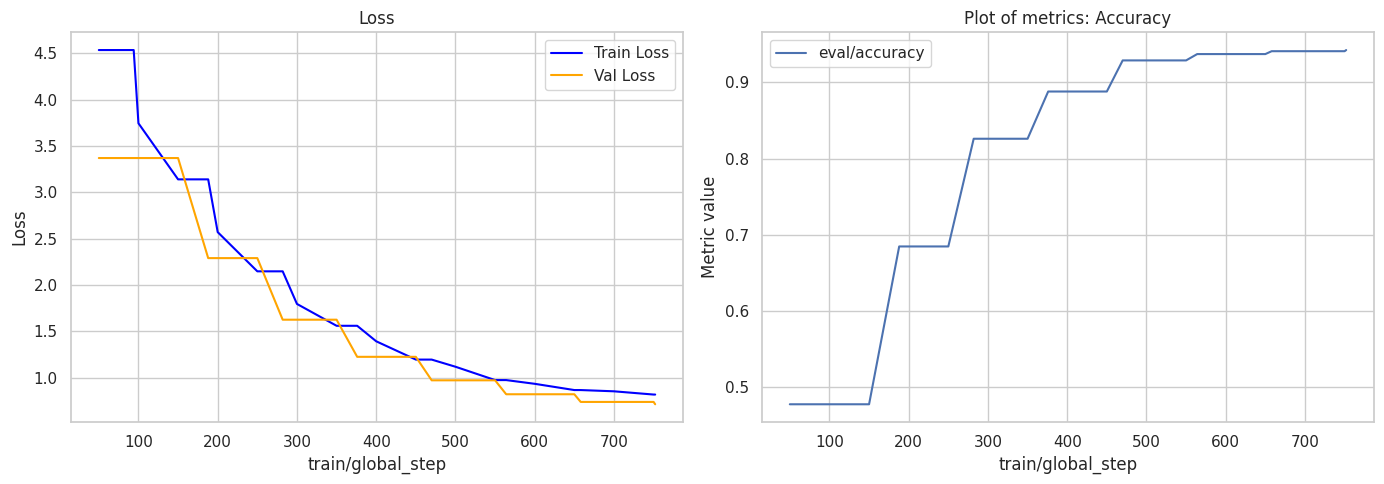

In [ ]:
plot_wandb_metrics(
    run_path='radyasrn-mipt/NLP-spring-2025/477sjrgb',
    metric_keys=['eval/accuracy'],
    title_suffix='Accuracy'
)

We can see that we have achieved a good accuracy. Now let's look at the accuracy on the test data:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "./rubert-intent-cls-model", num_labels=num_labels
)
model.eval()

dataloader = DataLoader(test_dataset, batch_size=128)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dataloader, leave=False):
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(model.device)
        logits = model(**inputs).logits
        preds = logits.argmax(dim=-1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

acc = accuracy_score(all_labels, all_preds)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
print(f'{acc:.3f}')

0.949


<a name="step-3-rubert-model-with-gradual-training-setup"></a>
<b><font size=4>**Step $3$</font></b> <b><font size=2>(RuBERT Model with Gradual Training Setup):**</font></b>

In this step, we will try to simulate a scenario where we have $122$ classes in the initial model deployment, and then new classes appear. We will then additionally train the last classification layer on the new classes, leaving the main transformer freezed during the additional training.

Let's prepare the data:

In [ ]:
train_df = pd.read_csv("/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv", sep="\t", header=None, names=["text", "label"])
test_df = pd.read_csv("/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv", sep="\t", header=None, names=["text", "label"])

all_labels = sorted(train_df["label"].unique())
initial_labels = all_labels[:122]

train_initial = train_df[train_df["label"].isin(initial_labels)].copy()
test_initial = test_df[test_df["label"].isin(initial_labels)].copy()

le_initial = LabelEncoder()
train_initial["label_id"] = le_initial.fit_transform(train_initial["label"])
test_initial["label_id"] = le_initial.transform(test_initial["label"])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_initial["text"], train_initial["label_id"], test_size=0.1, stratify=train_initial["label_id"], random_state=42
)

train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
val_dataset = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_initial["text"].tolist(), "label": test_initial["label_id"].tolist()})

train_dataset = train_dataset.map(tokenize).remove_columns(["text"])
val_dataset = val_dataset.map(tokenize).remove_columns(["text"])
test_dataset = test_dataset.map(tokenize).remove_columns(["text"])
train_dataset.set_format("torch")
val_dataset.set_format("torch")
test_dataset.set_format("torch")

Map:   0%|          | 0/10320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1147 [00:00<?, ? examples/s]

Map:   0%|          | 0/767 [00:00<?, ? examples/s]

We will train the model for $8$ epochs with `learning_rate=2e-5 and weight_decay=0.01`:

In [ ]:
wandb.init(project="NLP-spring-2025", name="rubert-intent-cls-122-classes-run-1")

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=122
)

training_args = TrainingArguments(
    output_dir="./results-rubert-intent-cls-122-classes",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1646557912.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.302700,3.189149,0.516129
2,2.767100,2.216558,0.718396
3,2.273500,1.603537,0.835222
4,1.574400,1.215080,0.884045
5,1.162600,0.975970,0.923278
6,1.049800,0.833435,0.932868
7,0.906200,0.756019,0.937228
8,0.852200,0.731680,0.940715


TrainOutput(global_step=648, training_loss=1.790860841303696, metrics={'train_runtime': 1006.4489, 'train_samples_per_second': 82.031, 'train_steps_per_second': 0.644, 'total_flos': 5436463295692800.0, 'train_loss': 1.790860841303696, 'epoch': 8.0})

Then we will finish the run:

In [ ]:
wandb.finish()

eval/accuracy,█▁▄▆▇████
eval/loss,▁█▅▄▂▂▁▁▁
eval/runtime,▁████████
eval/samples_per_second,█▁▄▄▄▄▄▅▄
eval/steps_per_second,█▁▃▃▃▃▃▄▃
train/epoch,█▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train/global_step,█▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇
train/grad_norm,██▇▆▅▅▃▃▂▂▂▁
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁
train/loss,█▆▅▄▃▂▂▂▁▁▁▁
eval/accuracy,0.94071


Then we will save the model:

In [ ]:
trainer.save_model("./rubert-intent-cls-122-classes-model")
tokenizer.save_pretrained("./rubert-intent-cls-122-classes-model")

('./rubert-intent-cls-122-classes-model/tokenizer_config.json',
 './rubert-intent-cls-122-classes-model/special_tokens_map.json',
 './rubert-intent-cls-122-classes-model/vocab.txt',
 './rubert-intent-cls-122-classes-model/added_tokens.json',
 './rubert-intent-cls-122-classes-model/tokenizer.json')

Let's look at the training history:

/tmp/ipykernel_31/3774981854.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history = history.fillna(method='ffill').fillna(method='bfill')


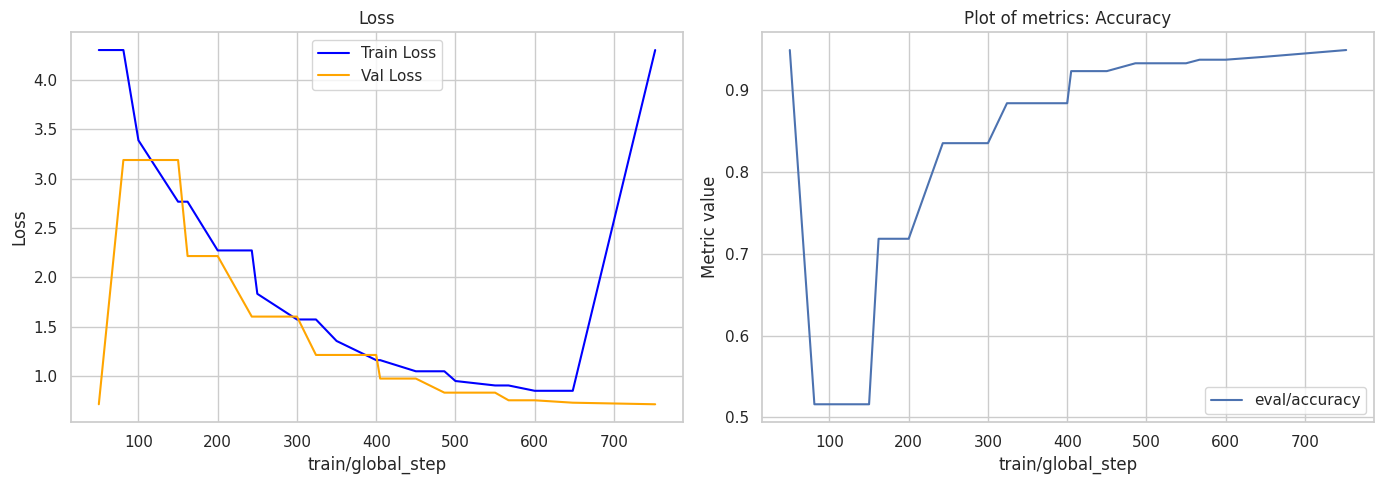

In [ ]:
plot_wandb_metrics(
    run_path='radyasrn-mipt/NLP-spring-2025/jycs93of',
    metric_keys=['eval/accuracy'],
    title_suffix='Accuracy'
)

Now let's look at the results on the test data:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "./rubert-intent-cls-122-classes-model", num_labels=122
)
model.eval()

dataloader = DataLoader(test_dataset, batch_size=128)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dataloader, leave=False):
        inputs = {k: v.to(model.device) for k, v in batch.items() if k != "label"}
        labels = batch["label"].to(model.device)
        logits = model(**inputs).logits
        preds = logits.argmax(dim=-1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

acc_122_classes = accuracy_score(all_labels, all_preds)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
print(f'{acc_122_classes:.3f}')

0.934


The result is slightly worse than that of the first model, but it should be noted that not all classes are taken into account here. Next, we will prepare the data for all classes for further training:

In [ ]:
train_df = pd.read_csv("/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv", sep="\t", header=None, names=["text", "label"])
test_df = pd.read_csv("/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv", sep="\t", header=None, names=["text", "label"])

le_full = LabelEncoder()
train_df["label_id"] = le_full.fit_transform(train_df["label"])
test_df["label_id"] = le_full.transform(test_df["label"])

train_dataset = Dataset.from_pandas(train_df[["text", "label_id"]])
test_dataset = Dataset.from_pandas(test_df[["text", "label_id"]])

train_dataset = train_dataset.map(tokenize).remove_columns(["text"]).with_format("torch")
test_dataset = test_dataset.map(tokenize).remove_columns(["text"]).with_format("torch")

train_indices, val_indices = train_test_split(
    list(range(len(train_dataset))), test_size=0.1, stratify=train_df["label_id"], random_state=42
)

train_subset = train_dataset.select(train_indices)
val_subset = train_dataset.select(val_indices)

Map:   0%|          | 0/13230 [00:00<?, ? examples/s]

Map:   0%|          | 0/883 [00:00<?, ? examples/s]

Let's get representations from a function that will receive the representation `[CLS]` token for all texts after passing through the transformer:

In [ ]:
model = AutoModel.from_pretrained("./rubert-intent-cls-122-classes-model").cuda()
model.eval()

X_train, y_train = extract_cls(train_subset, model)
X_val, y_val = extract_cls(val_subset, model)
X_test, y_test = extract_cls(test_dataset, model)

os.makedirs("repr_cache", exist_ok=True)
torch.save((X_train, y_train), "repr_cache/train.pt")
torch.save((X_val, y_val), "repr_cache/val.pt")
torch.save((X_test, y_test), "repr_cache/test.pt")

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Now we will train the classifier with a higher `learning_rate=1e-3`, the same `weight_decay=0.01`, and an increased number of epochs of $30$, since this is a fully connected network rather than a transformer:

In [ ]:
train_ds = Dataset.from_dict({"input_ids": X_train, "label": y_train})
val_ds = Dataset.from_dict({"input_ids": X_val, "label": y_val})

wandb.init(project="NLP-spring-2025", name="linear-intent-cls-142-classes-run-2")

model = LinearClassifier(in_dim=X_train.shape[1], num_classes=len(le_full.classes_))

training_args = TrainingArguments(
    output_dir="./results-linear-intent-cls-142-classes",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    weight_decay=0.01,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=30,
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_accuracy
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.330300,0.160663,0.943311
2,0.149000,0.129802,0.950113
3,0.127800,0.124666,0.950869
4,0.116700,0.116464,0.949358
5,0.117000,0.117555,0.952381
6,0.103600,0.118128,0.956160
7,0.099100,0.109156,0.958428
8,0.100200,0.108029,0.959940
9,0.099700,0.108506,0.957672
10,0.101000,0.104311,0.956160


TrainOutput(global_step=2820, training_loss=0.12266986357404831, metrics={'train_runtime': 182.2138, 'train_samples_per_second': 1960.39, 'train_steps_per_second': 15.476, 'total_flos': 0.0, 'train_loss': 0.12266986357404831, 'epoch': 30.0})

Then we will finish the run:

In [ ]:
wandb.finish()

eval/accuracy,▁▄▄▃▅▆▇█▇▆█▆▇█▇▆███▆██▆▆▆▆▆▇▆▆
eval/loss,█▅▄▃▃▃▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▂█▂▂▄▁▂▂▂▃▂▁▂▂▃▂▁▂▃▆▂▄▃▃▂▁▂▄▂▄
eval/samples_per_second,▇▁▇▇▅█▇▇▇▆▇█▇▇▆▇█▇▆▃▇▅▆▆▇█▇▅▇▅
eval/steps_per_second,▇▁▇▇▅█▇▇▇▆▇█▇▇▆▇█▇▆▃▇▅▆▆▇█▇▅▇▅
train/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇█████
train/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,█▄▅▅▆▆▅▅▆▅▅▇▄▄▄▃▃▆▃▄▄▅▅▄▃▄▅▃▅▄▅▃▆▁▆▆▆▅▃▄
train/learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁
train/loss,█▆▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁
eval/accuracy,0.95616


Then we will save the model:

In [ ]:
trainer.save_model("./linear-intent-cls-142-classes-model")
tokenizer.save_pretrained("./linear-intent-cls-142-classes-model")

('./linear-intent-cls-142-classes-model/tokenizer_config.json',
 './linear-intent-cls-142-classes-model/special_tokens_map.json',
 './linear-intent-cls-142-classes-model/vocab.txt',
 './linear-intent-cls-142-classes-model/added_tokens.json',
 './linear-intent-cls-142-classes-model/tokenizer.json')

Let's look at the training history:

/tmp/ipykernel_31/3774981854.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history = history.fillna(method='ffill').fillna(method='bfill')


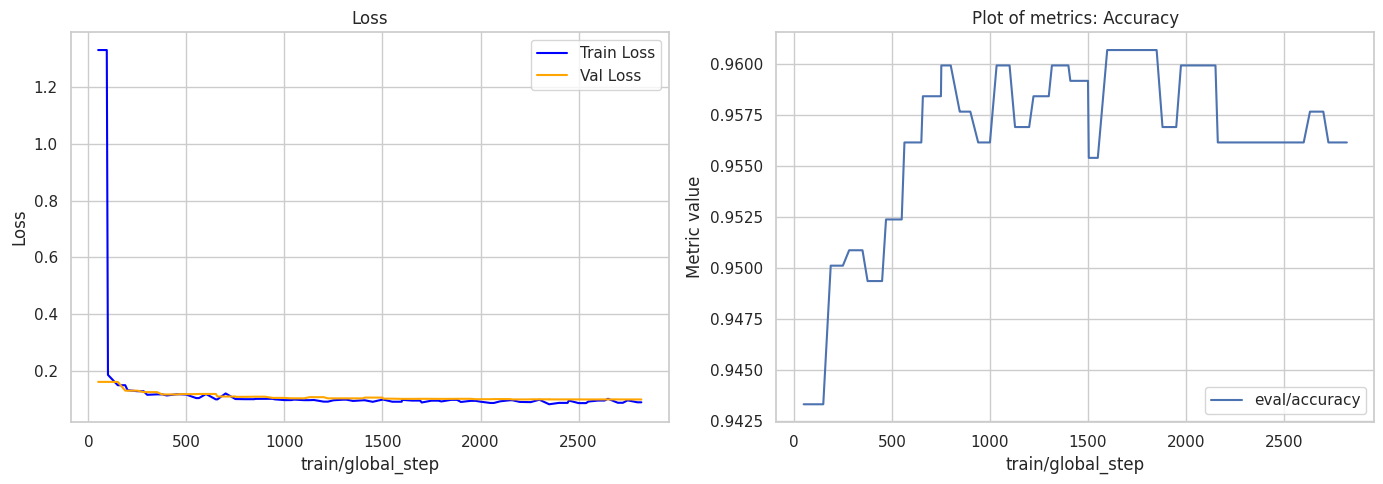

In [ ]:
plot_wandb_metrics(
    run_path='radyasrn-mipt/NLP-spring-2025/d4kte2qt',
    metric_keys=['eval/accuracy'],
    title_suffix='Accuracy'
)

We can see that accuracy is high. Let's look at the results on the test data:

In [ ]:
test_ds = TensorDataset(X_test, y_test)

model = LinearClassifier(in_dim=768, num_classes=142)
state_dict = load_file("./linear-intent-cls-142-classes-model/model.safetensors")
model.load_state_dict(state_dict)
model.cuda()
model.eval()

dataloader = DataLoader(test_ds, batch_size=128)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dataloader, leave=False):
        x, y = batch
        x = x.to('cuda')
        y = y.to('cuda')
        logits = model(input_ids=x).logits
        preds = logits.argmax(dim=-1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

acc_142_classes = accuracy_score(all_labels, all_preds)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
print(f'{acc_142_classes:.3f}')

0.949


<a name="step-4-rubert-model-with-augmentex-augmentations"></a>
<b><font size=4>**Step $4$</font></b> <b><font size=2>(RuBERT Model with Augmentex Augmentations):**</font></b>

In this step, we will train the first RuBERT model with augmentations from `augmentex`.

We will use replace and typo (which is especially important, since people often write to chatbots via their phones), as they are the fastest and do not require loading language models, unlike other augmentations. Let's install `augmentex`:

In [ ]:
!pip install git+https://github.com/ai-forever/augmentex.git

Let's create the datasets:

In [ ]:
train_df = pd.read_csv("/kaggle/input/qa-intents-dataset-university-domain/dataset_train.tsv", sep="\t", header=None, names=["text", "label"])
test_df = pd.read_csv("/kaggle/input/qa-intents-dataset-university-domain/dataset_test.tsv", sep="\t", header=None, names=["text", "label"])

le = LabelEncoder()
train_df["label_id"] = le.fit_transform(train_df["label"])
test_df["label_id"] = le.transform(test_df["label"])

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"], train_df["label_id"], test_size=0.1, stratify=train_df["label_id"], random_state=42
)

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

train_dataset = AugmentedIntentDataset(
    texts=train_texts.tolist(),
    labels=train_labels.tolist(),
    tokenizer=tokenizer,
    augment=True,
    augment_kwargs={"augmentations": ["replace", "typo"]}
)

val_dataset = AugmentedIntentDataset(
    texts=val_texts.tolist(),
    labels=val_labels.tolist(),
    tokenizer=tokenizer,
    augment=True,
    augment_kwargs={"augmentations": ["replace", "typo"]}
)


test_dataset = AugmentedIntentDataset(
    texts=test_df["text"].tolist(),
    labels=test_df["label_id"].tolist(),
    tokenizer=tokenizer,
    augment=False
)

Then we will train the model for $8$ epochs with `learning_rate=2e-5`, `weight_decay=0.01`:

In [ ]:
wandb.init(project="NLP-spring-2025", name="rubert-intent-cls-with-augmentex-run-2")

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(le.classes_)
)

training_args = TrainingArguments(
    output_dir="./results-rubert-intent-cls-with-augmentex",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=1,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1096418317.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,4.652600,3.935990,0.213152
2,3.810200,3.408198,0.296296
3,3.314100,3.012406,0.377173
4,2.946900,2.732429,0.422525
5,2.695900,2.505434,0.468632
6,2.517800,2.365288,0.506425
7,2.410400,2.298048,0.527589
8,2.374300,2.261744,0.523810


TrainOutput(global_step=752, training_loss=3.053412743705384, metrics={'train_runtime': 1189.5474, 'train_samples_per_second': 80.078, 'train_steps_per_second': 0.632, 'total_flos': 6273602712760320.0, 'train_loss': 3.053412743705384, 'epoch': 8.0})

Then we will finish the run:

In [ ]:
wandb.finish()

eval/accuracy,▁▃▅▆▇███
eval/loss,█▆▄▃▂▁▁▁
eval/runtime,▄▂▂▂▃█▄▁
eval/samples_per_second,▅▇▇▇▆▁▅█
eval/steps_per_second,▆█▇▇▆▁▅█
train/epoch,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
train/global_step,▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
train/grad_norm,▁▁▅▂▃▄█▅▄▅▄▅▄▅▅
train/learning_rate,██▇▇▆▆▅▅▄▄▃▃▂▂▁
train/loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁▁
eval/accuracy,0.52381


Then we will save the model:

In [ ]:
trainer.save_model("./rubert-intent-cls-with-augmentex-model")
tokenizer.save_pretrained("./rubert-intent-cls-with-augmentex-model")

('./rubert-intent-cls-with-augmentex-model/tokenizer_config.json',
 './rubert-intent-cls-with-augmentex-model/special_tokens_map.json',
 './rubert-intent-cls-with-augmentex-model/vocab.txt',
 './rubert-intent-cls-with-augmentex-model/added_tokens.json',
 './rubert-intent-cls-with-augmentex-model/tokenizer.json')

Let's look at the training history:

/tmp/ipykernel_31/3774981854.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  history = history.fillna(method='ffill').fillna(method='bfill')


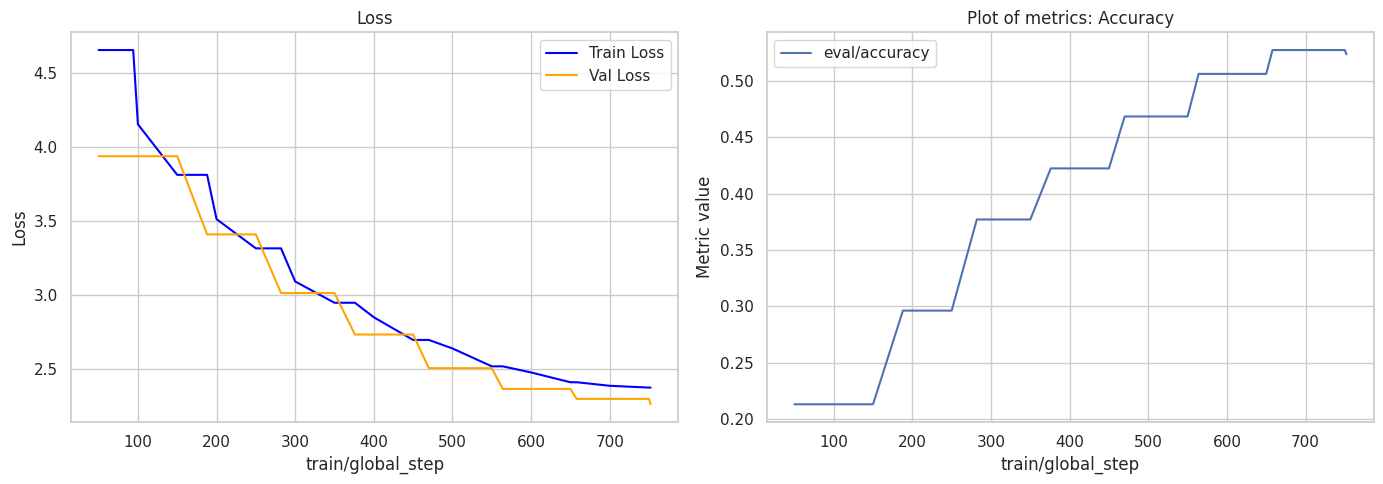

In [ ]:
plot_wandb_metrics(
    run_path='radyasrn-mipt/NLP-spring-2025/fb3hmeta',
    metric_keys=['eval/accuracy'],
    title_suffix='Accuracy'
)

We see a noticeable drop in accuracy, so augmentation is probably not worth using. Let's look at the test results:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "./rubert-intent-cls-with-augmentex-model",
    num_labels=len(le.classes_)
)
model.eval()
model.cuda()

dataloader = DataLoader(test_dataset, batch_size=128)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(dataloader, leave=False):
        inputs = {
            "input_ids": batch["input_ids"].to(model.device),
            "attention_mask": batch["attention_mask"].to(model.device)
        }
        labels = batch["labels"].to(model.device)
        logits = model(**inputs).logits
        preds = logits.argmax(dim=-1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
acc_142_classes_with_augmentex = accuracy_score(all_labels, all_preds)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
print(f'{acc_142_classes_with_augmentex:.3f}')

0.570


<a name="step-5-final-comparison-of-models"></a>
<b><font size=4>**Step $5$</font></b> <b><font size=2>(Final Comparison of Models):**</font></b>

Let's compare the results with the previously calculated accuracy values:

In [ ]:
results_intent_classification = pd.DataFrame({
    "model": ["baseline_142_classes",
              "only_122_classes",
              "only_122_classes_finetune_on_142_classes",
              "142_classes_with_augmentations"
    ],
    "accuracy": [acc, acc_122_classes, acc_142_classes, acc_142_classes_with_augmentex]
})

results_intent_classification = results_intent_classification.round(3)
results_intent_classification

,model,accuracy
0,baseline_142_classes,0.949
1,only_122_classes,0.934
2,only_122_classes_finetune_on_142_classes,0.949
3,142_classes_with_augmentations,0.570


We see that the first three models showed good results and that the method used in the third model is practical. However, the augmentations in the fourth model only worsened the quality.